In [34]:
import xarray as xr
import numpy as np


import cartopy.crs as ccrs

import copy

import matplotlib
import matplotlib.pyplot as plt

import copy
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes

from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc

In [35]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

# First batch of experiments:

In [36]:
runs_configs = {
    "diffusion": ("rasp_thuerey_z_500_3day",  "diffusion", "2023-09-13_19-47-27", "2023-09-14_09-45-42"),
    "diffusion_10Members": ("rasp_thuerey_z_500_3day",  "diffusion", "2023-09-13_19-47-27", "2023-09-14_10-29-54"),
    "diffusion_CosineAnnealing": ("rasp_thuerey_z_500_3day",  "diffusion_CosineAnnealing", "2023-09-13_22-56-04", "2023-09-14_09-51-06"),
    "diffusion_deeper": ("rasp_thuerey_z_500_3day",  "diffusion_deeper", "2023-09-13_20-06-24", "2023-09-14_09-46-02"),
    "diffusion_wider": ("rasp_thuerey_z_500_3day",  "diffusion_wider", "2023-09-13_20-04-33", "2023-09-14_09-46-01"),
    "diffusion_MSE_Loss": ("rasp_thuerey_z_500_3day",  "diffusion_MSE_Loss", "2023-09-13_21-22-12", "2023-09-14_09-52-21"),
    "diffusion_2csteps": ("rasp_thuerey_z_500_3day_2csteps",  "diffusion_2csteps", "2023-09-13_22-18-16", "2023-09-14_10-09-09"),
    "diffusion_more_patient_deeper": ("rasp_thuerey_z_500_3day",  "diffusion_more_patient_deeper", "2023-09-14_14-38-48", "2023-09-15_15-44-47"),
    "diffusion_MSE_Loss_more_patient_deeper": ("rasp_thuerey_z_500_3day",  "diffusion_MSE_Loss_more_patient_deeper", "2023-09-14_14-35-24", "2023-09-15_11-22-31"),
    "fourcastnet": ("rasp_thuerey_z_500_3day",  "fourcastnet", "2023-09-17_00-45-26", "2023-09-17_16-10-27"),
    # "unet_t2m_highres": ("rasp_thuerey_highres_t2m_5day",  "unet_highres_t2m", "2023-09-16_22-01-42", "2023-09-18_04-51-50"),
    # "diffusion_t2m_highres": ("rasp_thuerey_highres_t2m_5day", "diffusion_t2m_5day_highres", "2023-09-17_07-19-57","2023-09-18_09-12-59"),
}

predictions = dict()
targets = dict()
diff = dict()

for key, r_config in runs_configs.items():
    targets[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/target.nc".format(*r_config))
    predictions[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format(*r_config))
    diff[key] = targets[key] - predictions[key]


In [37]:
n_images = 8

timesteps = np.random.choice(np.arange(len(predictions[key]["init_time"])), size=(n_images,))

In [38]:
for key in runs_configs.keys():
    rmse = compute_weighted_rmse(predictions[key].isel({"ensemble_member": 0}), targets[key].isel({"ensemble_member": 0}))
    print("RMSE {} is {:.1f}".format(key, rmse.z_500.values))

RMSE diffusion is 679.6
RMSE diffusion_10Members is 679.2
RMSE diffusion_CosineAnnealing is 675.8
RMSE diffusion_deeper is 671.1
RMSE diffusion_wider is nan
RMSE diffusion_MSE_Loss is 646.4
RMSE diffusion_2csteps is 691.8
RMSE diffusion_more_patient_deeper is 595.1
RMSE diffusion_MSE_Loss_more_patient_deeper is 636.6
RMSE fourcastnet is 478.7


#### Ensemble mean RMSE vs Mean of RMSEs of members

In [39]:
rmse_ensemble_mean = compute_weighted_rmse(predictions["diffusion_10Members"].mean("ensemble_member"), targets["diffusion_10Members"].mean("ensemble_member"))

rmse = []
for i in range(len(predictions["diffusion_10Members"].ensemble_member)):
    rmse.append(compute_weighted_rmse(predictions["diffusion_10Members"].isel({"ensemble_member": i}), targets["diffusion_10Members"].isel({"ensemble_member": 0})))

mean_of_ensemble_rmse = np.mean([r.z_500.values for r in rmse])
std_of_ensemble_rmse = np.std([r.z_500.values for r in rmse])


print(f"RMSE of ensemble Mean: {rmse_ensemble_mean}")
print(f"Ensemble or RMSEs: {mean_of_ensemble_rmse:.1f} +/- {std_of_ensemble_rmse:.1f}")

RMSE of ensemble Mean: <xarray.Dataset>
Dimensions:  ()
Data variables:
    z_500    float64 643.5
Ensemble or RMSEs: 679.3 +/- 0.3


# Plot a few timesteps:

In [40]:
# do configurations for plotting - these can also be shared or "inherited" for plots that are similar!

config = {
    "CMAP": "viridis",
    "NORM": matplotlib.colors.Normalize(vmin=49000, vmax=59000),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": False,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "both",
    "SHOW_COLORBAR_LABEL": False,
    "CBAR_LABEL": r"Geopotential [$m^2/s^2$]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 5.5/5  # can be used to calculate a figsize that looks nice for a given type of plot
}


config_diff = copy.deepcopy(config)

config_diff["CMAP"] = "RdBu"
config_diff["NORM"] = matplotlib.colors.Normalize(vmin=-3000, vmax=3000)

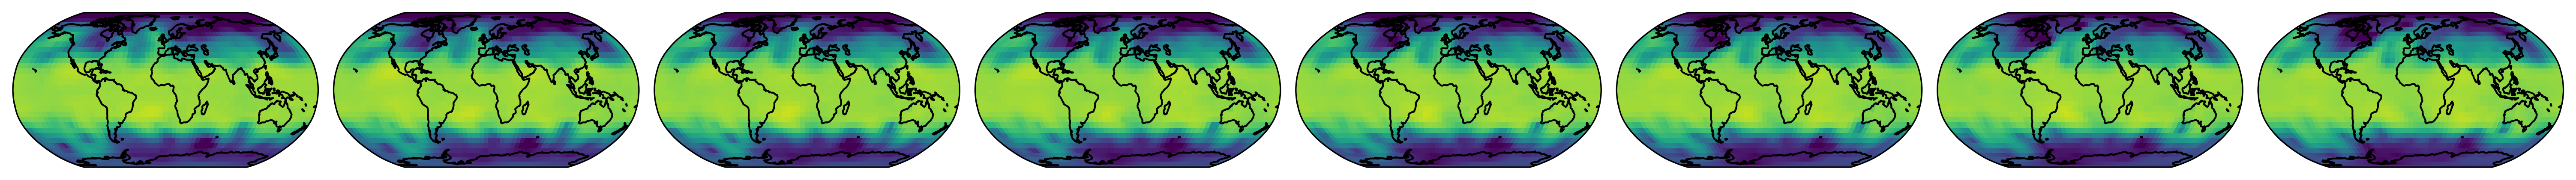

In [41]:
n_rows = 1
n_cols = 8

figure_width = textwidth * 3
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * 3 *(n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=n_cols*[1])
for i in range(n_cols):
    if i == n_rows - 1:
        config["SHOW_COLORBAR_LABEL"] = True
        config_diff["SHOW_COLORBAR_LABEL"] = True
    else:
        config["SHOW_COLORBAR_LABEL"] = False
        config_diff["SHOW_COLORBAR_LABEL"] = False

    ax = fig.add_subplot(gs[0, i], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=targets["diffusion"].isel({"init_time":i, "lead_time":0, "ensemble_member": 0})[["z_500"]], plotting_config=config)

fig.canvas.draw()
fig.tight_layout()

plt.savefig("/home/wider/Projects/diffusion-models-for-weather-prediction/images/chronologic_timesteps.jpg")

# Iterative runs:

In [45]:
runs_configs = {
    "iterative_z_500": ("iterative_z_500",  "iterative_diffusion_z_500", "2023-09-08_23-09-27", "2023-09-14_19-27-28"),
    "iterative_t_850": ("iterative_t_850",  "iterative_diffusion_t_850", "2023-09-14_13-11-43", "2023-09-14_19-53-51"),
    # "iterative_z_500_highres": ("iterative_z_500_highres",  "iterative_diffusion_z_500_highres", "", ""),
    # "iterative_t_850_highres": ("iterative_t_850_highres",  "iterative_diffusion_t_850_highres", "", ""),
    # "iterative_reduced_set": ("iterative_reduced_set",  "iterative_diffusion_reduced_set", "", ""),
    # "iterative_z_500_t_850": ("iterative_z_500_t_850",  "iterative_diffusion_z_500_t_850", "", ""),
}

In [46]:
predictions = dict()
targets = dict()
diff = dict()

n_steps = 20 - 1

for key, r_config in runs_configs.items():
    targets[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/target.nc".format(*r_config)).isel({"init_time":slice(None, -n_steps)})
    predictions[key] = xr.load_dataset("/data/compoundx/WeatherDiff/model_output/{}/{}/{}/{}/gen.nc".format(*r_config)).isel({"init_time":slice(None, -n_steps)})
    diff[key] = targets[key] - predictions[key]

In [47]:
t_0 = 273.15
targets["iterative_t_850"] = targets["iterative_t_850"] - t_0
predictions["iterative_t_850"] = predictions["iterative_t_850"] - t_0

In [48]:
rmse = dict()

for key in runs_configs.keys():
    rmse[key] = []
    for j in range(len(predictions[key].lead_time)):
        rmse[key].append(compute_weighted_rmse(predictions[key].isel({"ensemble_member": 0, "lead_time": slice(j, j+1)}), targets[key].isel({"ensemble_member": 0, "lead_time": slice(j, j+1)})))

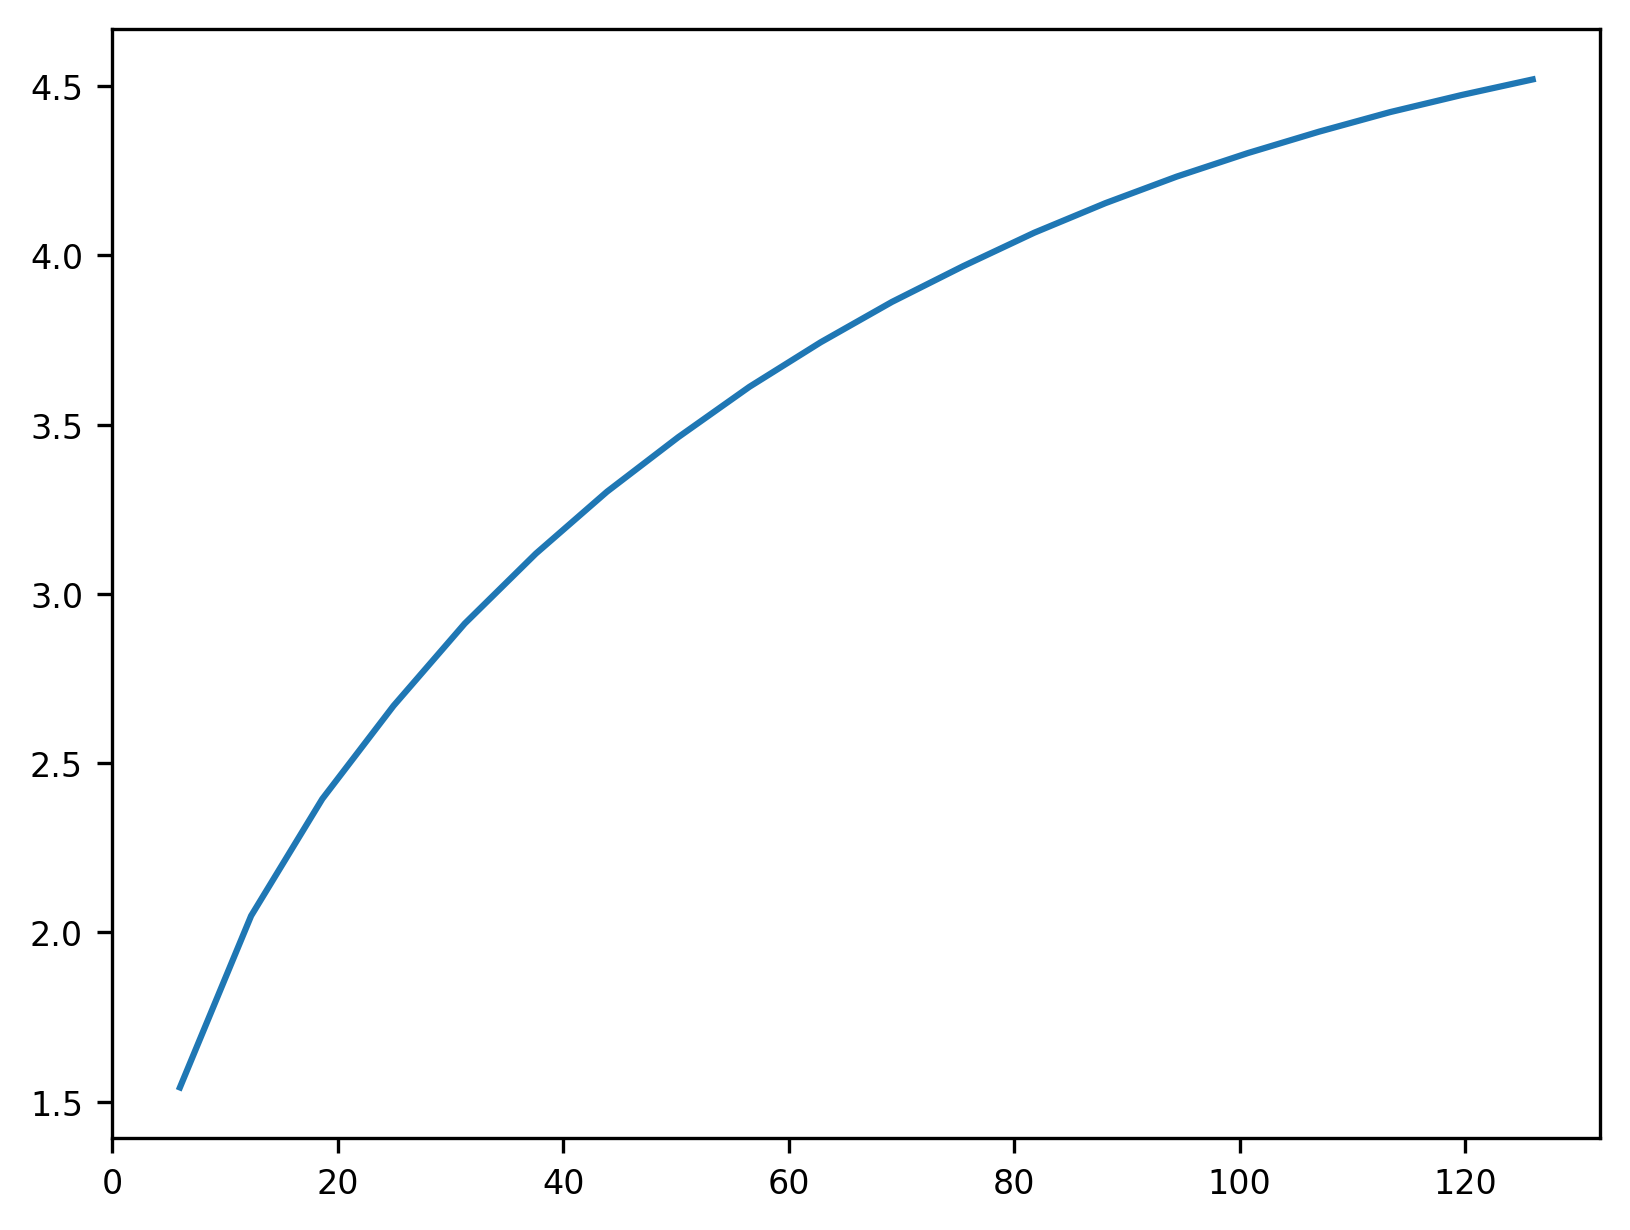

In [49]:
plt.plot(np.linspace(6, 21*6, 20), [r.t_850 for r in rmse["iterative_t_850"]])
plt.show()

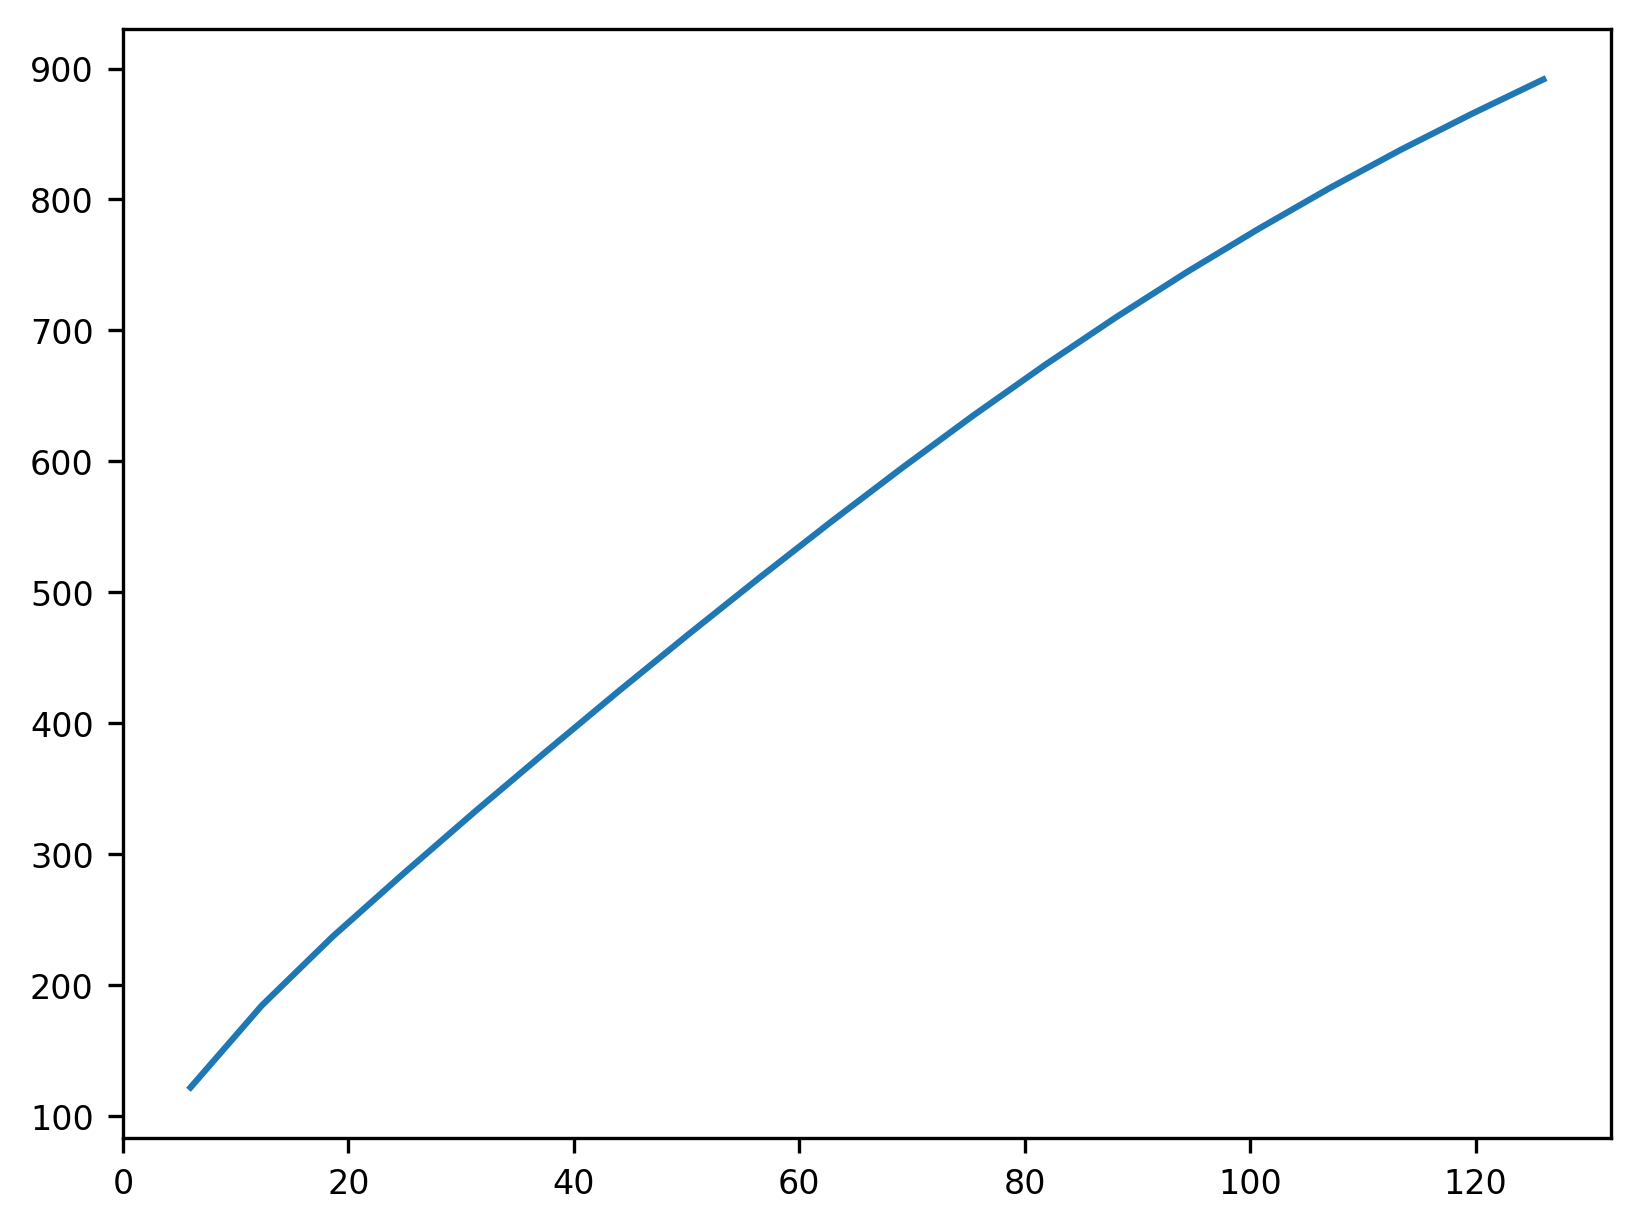

In [50]:
plt.plot(np.linspace(6, 21*6, 20), [r.z_500 for r in rmse["iterative_z_500"]])
plt.show()

In [51]:
config = {
    "CMAP": "coolwarm",
    "NORM": matplotlib.colors.Normalize(vmin=-30, vmax=30),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": True,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "both",
    "SHOW_COLORBAR_LABEL": True,
    "CBAR_LABEL": r"Temperature [°C]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 6/5  # can be used to calculate a figsize that looks nice for a given type of plot
}


config_diff = copy.deepcopy(config)

config_diff["CMAP"] = "PiYG"
config_diff["NORM"] = matplotlib.colors.Normalize(vmin=-25, vmax=25)

### create gif.

MovieWriter ffmpeg unavailable; using Pillow instead.


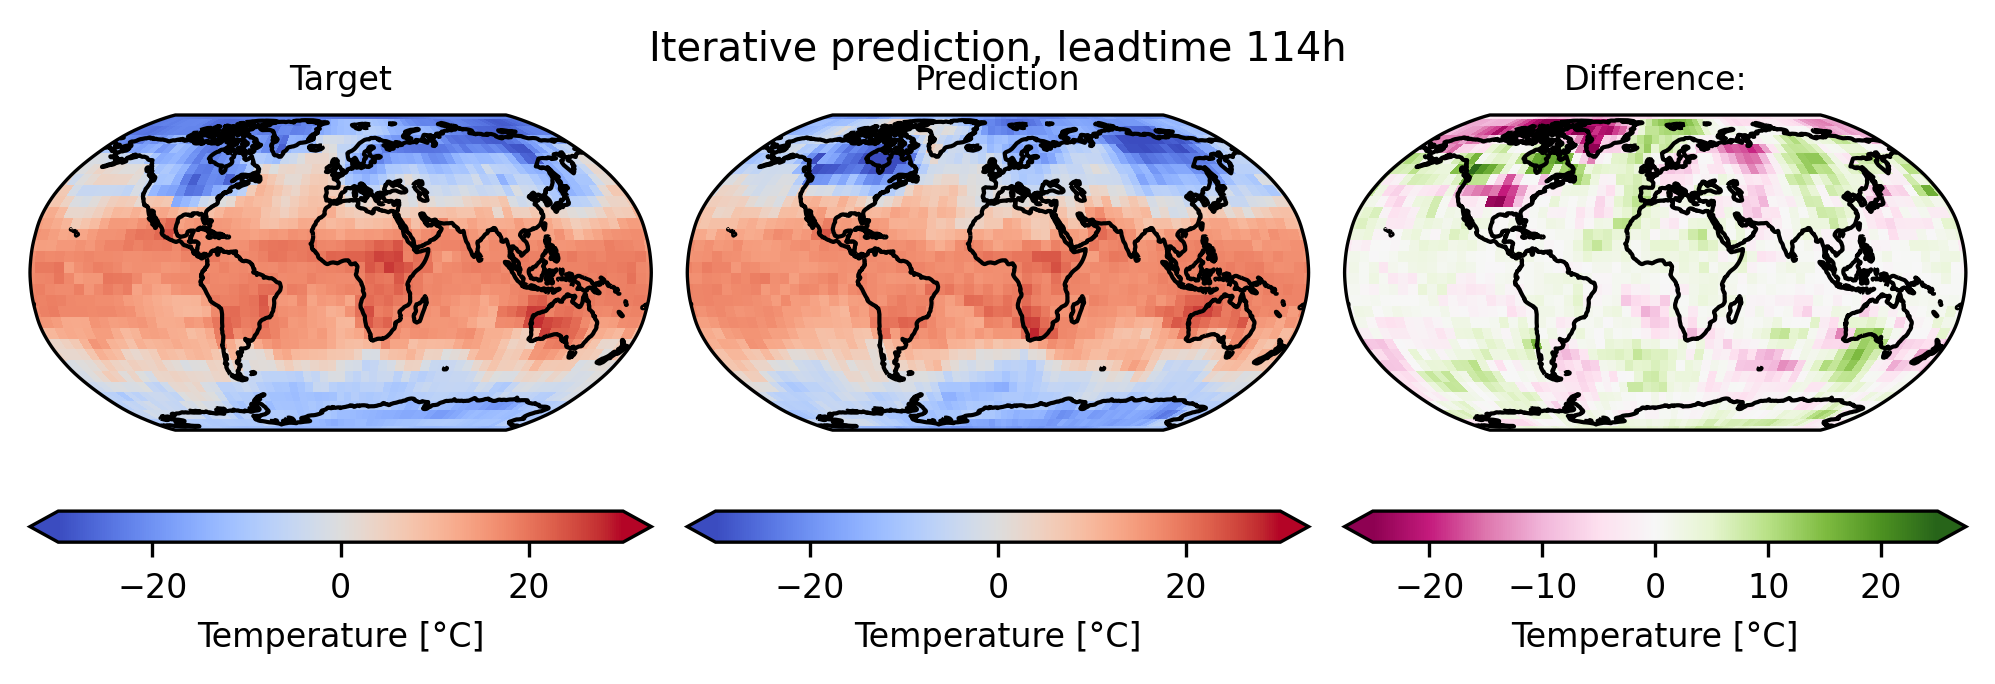

In [52]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from cartopy.util import add_cyclic_point

n_rows = 1
n_cols = 3

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"] * 1.2

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(1, n_cols, figure=fig, width_ratios=[1,1,1])


ax = fig.add_subplot(gs[0], projection=config["PROJECTION"])
# plot the map:
mesh_0 = plot_map(ax, data=targets["iterative_t_850"].isel({"init_time":0, "lead_time":0, "ensemble_member": 0})[["t_850"]], plotting_config=config, title="Target")

ax = fig.add_subplot(gs[1], projection=config["PROJECTION"])
# plot the map:
mesh_1 = plot_map(ax, data=predictions["iterative_t_850"].isel({"init_time":0, "lead_time":0, "ensemble_member": 0})[["t_850"]], plotting_config=config, title="Prediction")

ax = fig.add_subplot(gs[2], projection=config["PROJECTION"])
# plot the map:
mesh_2 = plot_map(ax, data=diff["iterative_t_850"].isel({"init_time":0, "lead_time":0, "ensemble_member": 0})[["t_850"]], plotting_config=config_diff, title="Difference:")

fig.canvas.draw()
fig.tight_layout()

def update_mesh(i):
    fig.suptitle("Iterative prediction, leadtime {:02d}h".format(6*(i+1)))
    data_0=targets["iterative_t_850"].isel({"init_time":0, "lead_time":i, "ensemble_member": 0})[["t_850"]]
    data_1=predictions["iterative_t_850"].isel({"init_time":0, "lead_time":i, "ensemble_member": 0})[["t_850"]]
    data_2=diff["iterative_t_850"].isel({"init_time":0, "lead_time":i, "ensemble_member": 0})[["t_850"]]
    p_data_0 = data_0[list(data_0.keys())[0]]
    p_data_1 = data_1[list(data_1.keys())[0]]
    p_data_2 = data_2[list(data_2.keys())[0]]

    lat = data_0.lat.values
    lon = data_0.lon.values

    ax.set_global()
    # remove white line
    field_0, _ = add_cyclic_point(p_data_0, coord=lon)
    field_1, _ = add_cyclic_point(p_data_1, coord=lon)
    field_2, _ = add_cyclic_point(p_data_2, coord=lon)
    mesh_0.set_array(field_0)
    mesh_1.set_array(field_1)
    mesh_2.set_array(field_2)

    fig.canvas.draw()
    # fig.tight_layout()

anim = animation.FuncAnimation(fig, update_mesh, frames=np.arange(n_steps),interval=300)
anim.save('images/t_850_lowres.gif')
plt.show()

In [55]:
config = {
    "CMAP": "viridis",
    "NORM": matplotlib.colors.Normalize(vmin=49000, vmax=59000),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": True,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "both",
    "SHOW_COLORBAR_LABEL": True,
    "CBAR_LABEL": r"Geopotential [$m^2/s^2$]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 6/5  # can be used to calculate a figsize that looks nice for a given type of plot
}


config_diff = copy.deepcopy(config)

config_diff["CMAP"] = "RdBu"
config_diff["NORM"] = matplotlib.colors.Normalize(vmin=-5000, vmax=5000)

MovieWriter ffmpeg unavailable; using Pillow instead.


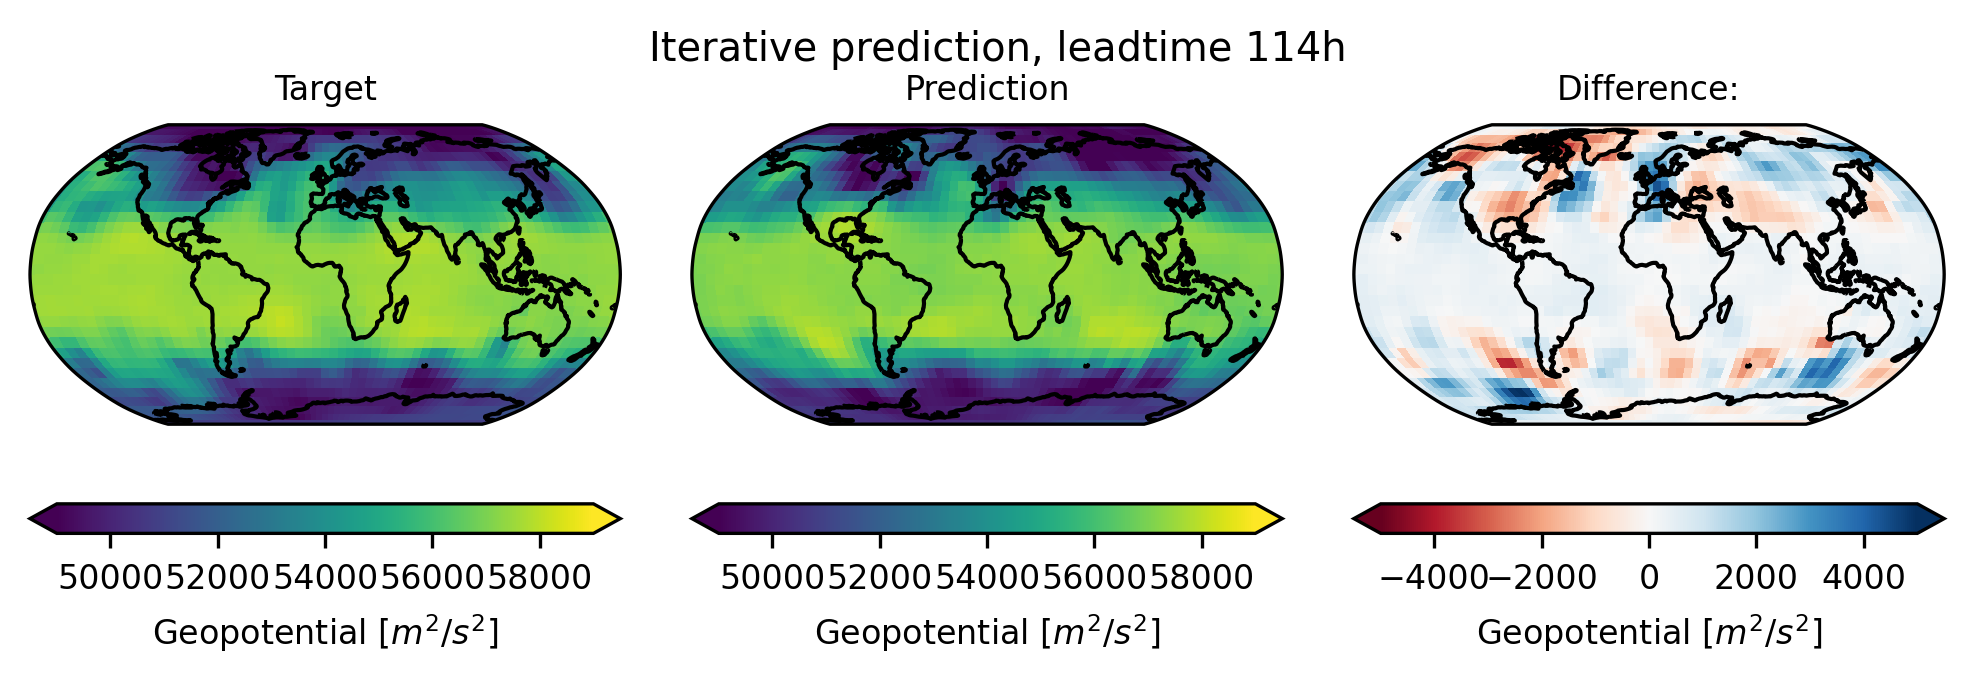

In [56]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from cartopy.util import add_cyclic_point

n_rows = 1
n_cols = 3

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"] * 1.2

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(1, n_cols, figure=fig, width_ratios=[1,1,1])


ax = fig.add_subplot(gs[0], projection=config["PROJECTION"])
# plot the map:
mesh_0 = plot_map(ax, data=targets["iterative_z_500"].isel({"init_time":0, "lead_time":0, "ensemble_member": 0})[["z_500"]], plotting_config=config, title="Target")

ax = fig.add_subplot(gs[1], projection=config["PROJECTION"])
# plot the map:
mesh_1 = plot_map(ax, data=predictions["iterative_z_500"].isel({"init_time":0, "lead_time":0, "ensemble_member": 0})[["z_500"]], plotting_config=config, title="Prediction")

ax = fig.add_subplot(gs[2], projection=config["PROJECTION"])
# plot the map:
mesh_2 = plot_map(ax, data=diff["iterative_z_500"].isel({"init_time":0, "lead_time":0, "ensemble_member": 0})[["z_500"]], plotting_config=config_diff, title="Difference:")

fig.canvas.draw()
fig.tight_layout()

def update_mesh(i):
    fig.suptitle("Iterative prediction, leadtime {:02d}h".format(6*(i+1)))
    data_0=targets["iterative_z_500"].isel({"init_time":0, "lead_time":i, "ensemble_member": 0})[["z_500"]]
    data_1=predictions["iterative_z_500"].isel({"init_time":0, "lead_time":i, "ensemble_member": 0})[["z_500"]]
    data_2=diff["iterative_z_500"].isel({"init_time":0, "lead_time":i, "ensemble_member": 0})[["z_500"]]
    p_data_0 = data_0[list(data_0.keys())[0]]
    p_data_1 = data_1[list(data_1.keys())[0]]
    p_data_2 = data_2[list(data_2.keys())[0]]

    lat = data_0.lat.values
    lon = data_0.lon.values

    ax.set_global()
    # remove white line
    field_0, _ = add_cyclic_point(p_data_0, coord=lon)
    field_1, _ = add_cyclic_point(p_data_1, coord=lon)
    field_2, _ = add_cyclic_point(p_data_2, coord=lon)
    mesh_0.set_array(field_0)
    mesh_1.set_array(field_1)
    mesh_2.set_array(field_2)

    fig.canvas.draw()
    # fig.tight_layout()

anim = animation.FuncAnimation(fig, update_mesh, frames=np.arange(n_steps),interval=300)
anim.save('images/z_500_lowres.gif')
plt.show()